In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import *
from models.vl_encoders import VLE_REGISTRY, MapComputeMode, VLEncoder
from data import get_many_answer_gt, get_many_answer_pr, CLASS_MAP, flatten_class_splitted_answers, get_sc, get_gt, get_pr, NUM_CLASSES
from color_map import apply_colormap, COLOR_MAP_DICT
from viz import overlay_map, display_token_length_distr, write_html_multi_row_image_caption, display_prompt
from path import SCS_PATH, GTS_PATH, get_mask_prs_path
from prompter import get_significant_classes_
from utils import flatten_list

import torch
import torchvision.transforms.v2.functional as TF
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image
from pathlib import Path

from typing import Optional

In [ ]:
# TODO use Git SubModules to integrate external repos in the project

# Attention Maps

In [4]:
def compute_maps_with_captions(
        model: VLEncoder,
        images: torch.Tensor,
        captions: list[str],
        map_compute_mode: MapComputeMode,
        viz_image_size: Optional[int | list[int]] = None,
        map_resize_mode: TF.InterpolationMode = TF.InterpolationMode.NEAREST,
        normalize: bool = True,
) -> list[tuple[Image.Image, str]]:
    image_text_list = []

    for img, text in zip(images, captions):
        img_tensor = model.preprocess_images([img], device=CONFIG['device'])
        text_tensor = model.preprocess_texts([text], device=CONFIG['device'])
        sim = model.get_similarity(img_tensor, text_tensor, broadcast=False)
        map, min_value, max_value = model.get_maps(
            img_tensor, text_tensor,
            map_compute_mode=map_compute_mode,
            upsample_size=viz_image_size, upsample_mode=map_resize_mode) # [1, H, W], M
        map = map.squeeze(0) # [1, H, W]
        if viz_image_size:
            img = TF.resize(img, size=viz_image_size, interpolation=TF.InterpolationMode.BILINEAR)
        ovr_img = overlay_map(img, map, normalize=normalize) # (H_viz, W_viz)

        image_text_list.append((ovr_img, f"SIM = {sim.item():.2f}", f"MIN VALUE = {min_value.item():.2f}, MAX VALUE = {max_value.item():.2f}", text, "---"))

    return image_text_list

In [5]:
model: VLEncoder = VLE_REGISTRY.get('flair', checkpoint='flair-cc3m-recap.pt')
# model: VLEncoder = VLE_REGISTRY.get('fg-clip', checkpoint='fg-clip-large')

In [6]:
# img_idxs = list(range(0, 8))
img_idxs = [9, 10, 11, 12, 13, 14, 15, 17]
viz_image_size = 300
map_compute_mode = MapComputeMode.ATTENTION
map_resize_mode = TF.InterpolationMode.NEAREST
normalize = True
alpha = 0.6 # 1.0 --> only scene, 0.0 only mask (0.0, 0.4, 1.0)

# TODO Find out if here it is 0.4 or 0.6 the correct one w.r.t to the 0.6 of the VLM

image_uids = image_UIDs[img_idxs]

In [7]:
scs_paths = [SCS_PATH / (UID + ".jpg") for UID in image_uids]
scs = [get_sc(p, resize_size=CONFIG['seg']['image_size'], center_crop=True) for p in scs_paths] # tensors (3, H, W)
len(scs)

8

## Non-splitted

In [8]:
answers_gt = get_many_answer_gt("LRASPP_MobileNet_V3", return_state=False, format_to_dict=True)
answers_gt_text = [answers_gt[i] for i in img_idxs]
len(answers_gt_text)

8

### Predictions Masks

In [9]:
def compute_pr_maps_with_captions(
        by_model: str,
        img_idxs: list[int],
        vle: VLEncoder,
        alpha: float,
        map_compute_mode: MapComputeMode,
        map_resize_mode: TF.InterpolationMode,
        viz_image_size: int | tuple[int, int],
        normalize: bool,
        contrastive: bool,
        class_map: dict[int, int] = CLASS_MAP,
        color_map_dict: dict[int, tuple[int, int, int]] = COLOR_MAP_DICT,
        original_resize_size: int | tuple[int, int] = CONFIG['seg']['image_size'],
) -> list[str | Image.Image]:
    answers_gt = get_many_answer_gt(by_model, return_state=False, format_to_dict=True)
    answers_gt_text = [answers_gt[i] for i in img_idxs]
    mask_prs_paths = [get_mask_prs_path(by_model) / f"mask_pr_{i}.png" for i in img_idxs]
    mask_prs = [apply_colormap([get_pr(p, class_map=class_map, resize_size=original_resize_size, center_crop=True)], color_map_dict).squeeze(0) for p in mask_prs_paths] # tensors (3, H, W)
    ovr_mask_prs = [to_tensor(Image.blend(to_pil_image(sc), to_pil_image(pr), alpha=alpha)) for pr, sc in zip(mask_prs, scs)]
    if contrastive:
        ovr_mask_prs = [ovr_mask_prs[0]]*int(len(ovr_mask_prs)/2) + [ovr_mask_prs[4]]*int(len(ovr_mask_prs)/2)
    pr_image_text_list = compute_maps_with_captions(vle, ovr_mask_prs, answers_gt_text, map_compute_mode=map_compute_mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode, normalize=normalize)
    return pr_image_text_list

In [10]:
pr_image_text_list = compute_pr_maps_with_captions(
    by_model="LRASPP_MobileNet_V3",
    img_idxs=img_idxs,
    vle=model,
    alpha=alpha,
    map_compute_mode=map_compute_mode,
    map_resize_mode=map_resize_mode,
    viz_image_size=viz_image_size,
    normalize=normalize,
    contrastive=False
)
# display_prompt(flatten_list(pr_image_text_list))

####  Contrastive analysis

In [11]:
con_pr_image_text_list = compute_pr_maps_with_captions(
    by_model="LRASPP_MobileNet_V3",
    img_idxs=img_idxs,
    vle=model,
    alpha=alpha,
    map_compute_mode=map_compute_mode,
    map_resize_mode=map_resize_mode,
    viz_image_size=viz_image_size,
    normalize=normalize,
    contrastive=True
)
# display_prompt(flatten_list(con_pr_image_text_list))

### Ground truth masks:

In [12]:
def compute_gt_maps_with_captions(
        by_model: str,
        img_idxs: list[int],
        vle: VLEncoder,
        alpha: float,
        map_compute_mode: MapComputeMode,
        map_resize_mode: TF.InterpolationMode,
        viz_image_size: int | tuple[int, int],
        normalize: bool,
        contrastive: bool,
        num_classes: int = NUM_CLASSES,
        class_map: dict[int, int] = CLASS_MAP,
        color_map_dict: dict[int, tuple[int, int, int]] = COLOR_MAP_DICT,
        original_resize_size: int | tuple[int, int] = CONFIG['seg']['image_size'],
) -> list[str | Image.Image]:
    answers_gt = get_many_answer_gt(by_model, return_state=False, format_to_dict=True)
    answers_gt_text = [answers_gt[i] for i in img_idxs]
    mask_gts_paths = [GTS_PATH / (UID + ".png") for UID in image_uids]
    mask_gts = [apply_colormap([get_gt(p, class_map=class_map, resize_size=original_resize_size, center_crop=True)], color_map_dict).squeeze(0) for p in mask_gts_paths] # tensors (3, H, W)
    ovr_mask_gts = [to_tensor(Image.blend(to_pil_image(sc), to_pil_image(gt), alpha=alpha)) for gt, sc in zip(mask_gts, scs)]
    if contrastive:
        ovr_mask_gts = [ovr_mask_gts[0]]*int(len(ovr_mask_gts)/2) + [ovr_mask_gts[4]]*int(len(ovr_mask_gts)/2)
    gt_image_text_list = compute_maps_with_captions(vle, ovr_mask_gts, answers_gt_text, map_compute_mode=map_compute_mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode, normalize=normalize)
    return gt_image_text_list

In [13]:
gt_image_text_list = compute_gt_maps_with_captions(
    by_model="LRASPP_MobileNet_V3",
    img_idxs=img_idxs,
    vle=model,
    alpha=alpha,
    map_compute_mode=map_compute_mode,
    map_resize_mode=map_resize_mode,
    viz_image_size=viz_image_size,
    normalize=normalize,
    contrastive=False
)
# display_prompt(flatten_list(gt_image_text_list))

In [14]:
pr_images_row = [el[0] for el in pr_image_text_list]
gt_images_row = [el[0] for el in gt_image_text_list]
captions = answers_gt_text

In [15]:
rows = {"PR masks": pr_images_row, "GT masks": gt_images_row}

In [16]:
write_html_multi_row_image_caption(rows, captions)

Successfully created index.html. Open it in your browser to see the result.


## Class-splitted

### Prediction Masks

In [17]:
def compute_cs_pr_maps_with_captions(
        by_model: str,
        img_idxs: list[int],
        vle: VLEncoder,
        alpha: float,
        map_compute_mode: MapComputeMode,
        map_resize_mode: TF.InterpolationMode,
        viz_image_size: int | tuple[int, int],
        normalize: bool,
        num_classes: int = NUM_CLASSES,
        class_map: dict[int, int] = CLASS_MAP,
        original_resize_size: int | tuple[int, int] = CONFIG['seg']['image_size'],
) -> list[str | Image.Image]:
    mask_prs_paths = [get_mask_prs_path(by_model) / f"mask_pr_{i}.png" for i in img_idxs]
    prs_path = Path("/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/class-splitted/answer_prs/gemma3:12b-it-qat/speed_test/SepMasks_Ovr_1fs.jsonl")
    cs_answers_pr = get_many_answer_pr(prs_path, return_state=False, format_to_dict=True)
    cs_answers_pr_text = [list(cs_answers_pr[i].values()) for i in img_idxs]
    significant_classes_pr = [get_significant_classes(get_mask_prs_path(by_model) / (f"mask_pr_{i}.png"), original_resize_size, class_map)  for i in img_idxs]
    cs_color_map_dicts = [list({c: [255, 255, 255] if c == pos_class else [0, 0, 0] for c in range(num_classes)} for pos_class in classes) for classes in significant_classes_pr]
    cs_mask_prs = [list(apply_colormap([get_pr(mask_prs_paths[i], class_map=class_map, resize_size=original_resize_size, center_crop=True)], cs_color_map_dicts[i][t]).squeeze(0) for t, pos_class in enumerate(classes)) for i, classes in enumerate(significant_classes_pr)]
    cs_ovr_mask_prs = [list(to_tensor(Image.blend(to_pil_image(sc), to_pil_image(pr), alpha=alpha)) for pr in cs_prs) for cs_prs, sc in zip(cs_mask_prs, scs)]
    cs_pr_image_text_list = [compute_maps_with_captions(vle, ovr_mask_prs, answers_pr_text, map_compute_mode=map_compute_mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode, normalize=normalize) for ovr_mask_prs, answers_pr_text in zip(cs_ovr_mask_prs, cs_answers_pr_text)]
    return cs_pr_image_text_list

In [18]:
cs_pr_image_text_list = compute_cs_pr_maps_with_captions(
    by_model="LRASPP_MobileNet_V3",
    img_idxs=img_idxs,
    vle=model,
    alpha=alpha,
    map_compute_mode=map_compute_mode,
    map_resize_mode=map_resize_mode,
    viz_image_size=viz_image_size,
    normalize=normalize,
)
# display_prompt(flatten_list(cs_pr_image_text_list))

# Token Length Analysis

**Ground truths** (non-splitted):

In [19]:
answers_gt = get_many_answer_gt("LRASPP_MobileNet_V3", return_state=False)
captions = [a['content'] for a in answers_gt]
tok_lengths = [model.count_tokens(t) for t in captions]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.context_length])
len(tok_lengths)

80

critical_answers_amount=4


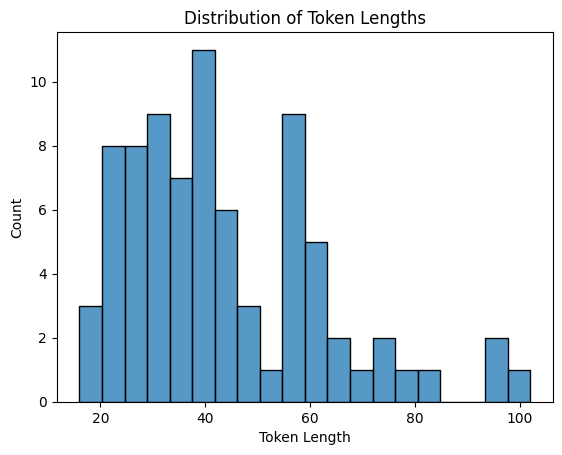

In [20]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

**Class-splitted predictions**:

In [21]:
prs_path = Path("/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/class-splitted/answer_prs/gemma3:12b-it-qat/speed_test/SepMasks_Ovr_1fs.jsonl")
answers_pr = flatten_class_splitted_answers(get_many_answer_pr(prs_path, return_state=False))
answers_pr_text = [a['content'] for a in answers_pr]
tok_lengths = [model.count_tokens(t) for t in answers_pr_text]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.context_length])
len(tok_lengths)

144

critical_answers_amount=2


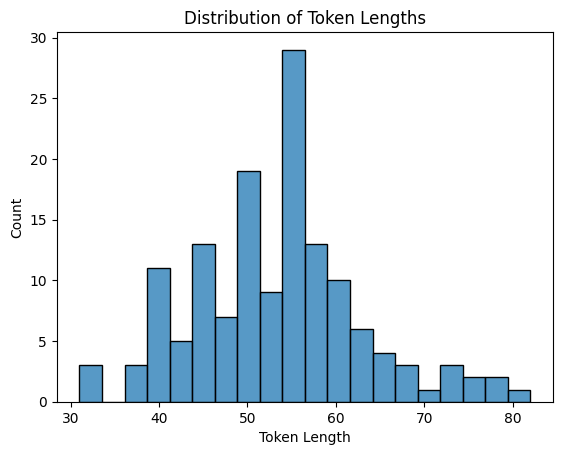

In [22]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

**Non-splitted predictions**:

In [23]:
prs_path = Path("/home/olivieri/exp/my_data/by_model/LRASPP_MobileNet_V3/non-splitted/answer_prs/gemini-2.0-flash/baseline/SepMasks_Ovr.jsonl")
answers_pr = get_many_answer_pr(prs_path, return_state=False)
answers_pr_text = [a['content'] for a in answers_pr]
tok_lengths = [model.count_tokens(t) for t in answers_pr_text]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.context_length])
len(tok_lengths)

77

critical_answers_amount=3


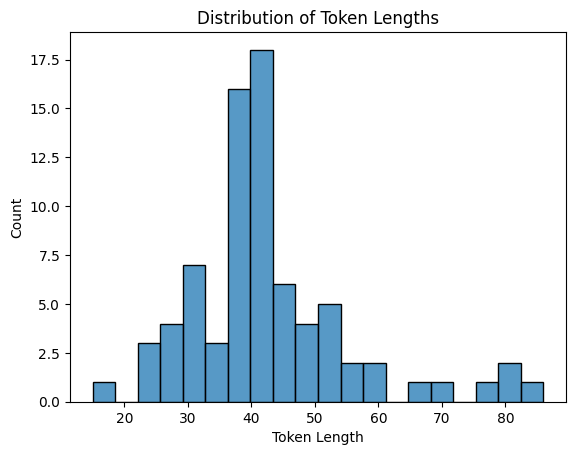

In [24]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

# Demo

In [25]:
model: VLEncoder = VLE_REGISTRY.get('flair')
# model: VLEncoder = VLE_REGISTRY.get('fg-clip')

In [26]:
map_compute_mode = MapComputeMode.ATTENTION
map_resize_mode = TF.InterpolationMode.NEAREST

(453, 604)


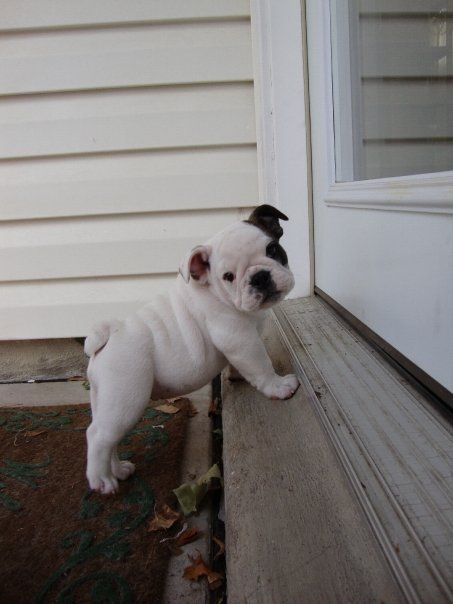

In [27]:
image = Image.open("/home/olivieri/exp/resources/puppy.jpg")
# image = Image.open("/home/olivieri/exp/resources/frappuccino.png")
print(image.size)
image

In [28]:
images_tensor = model.preprocess_images([image])
images_tensor.shape

torch.Size([1, 3, 224, 224])

In [29]:
texts_tensor = model.preprocess_texts([
    "In the image, a small white puppy with black ears and eyes is the main subject", # ground-truth caption
    "The white door behind the puppy is closed, and there's a window on the right side of the door", # ground-truth caption
    "A red ladybug is surrounded by green glass beads", # non-ground-truth caption
    "Dominating the scene is a white desk, positioned against a white brick wall" # non-ground-truth caption
    # "The background, though blurred, reveals a parking lot filled with cars.",
    # "Despite the background, the frappuccino remains the star of the image."
]).to(CONFIG['device'])

In [30]:
# with torch.no_grad(), torch.cuda.amp.autocast():
with torch.no_grad(), torch.amp.autocast(CONFIG['device']):
    flair_logits = model.get_similarity(images=images_tensor, texts=texts_tensor, broadcast=True)

flair_logits # [4.4062,  6.9531, -20.5000, -18.1719]

tensor([[ 0.2812,  0.3538, -0.0869, -0.0051]], device='cuda:0',
       dtype=torch.float16)

In [31]:
maps, min_value, max_value = model.get_maps(images_tensor, texts_tensor, map_compute_mode=map_compute_mode, upsample_size=image.size[::-1], upsample_mode=map_resize_mode, broadcast=True)
maps.shape

torch.Size([1, 4, 604, 453])

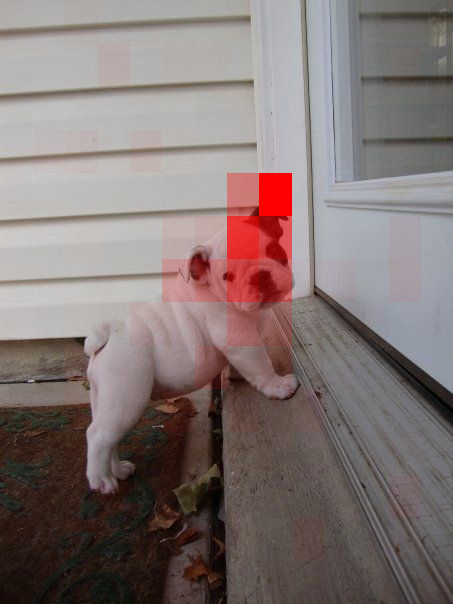

In [32]:
overlay_map(image, maps[0][0].unsqueeze(0))